# Example Temporal Logic Monitoring in Python

RTAMT is a Python library for monitoring Signal Temporal Logic (STL). It supports both offline and online monitoring of discrete-time and dense-time STL specifications. This tutorial provides a step-by-step guide to installing and using RTAMT.

For more details, refer to the [RTAMT GitHub repository](https://github.com/nickovic/rtamt).

## Installation

Install the following package for RTAMT:

In [ ]:
%pip install rtamt

## Usage

rtamt can be used in four ways:
- **discrete-time** (discrete time-steps) versus **dense-time** (continuous signals), and
- **online** (signal values are added one-at-a-time) versus **offline** (the entire trace is available)

### Discrete-Time Online Monitor
The `StlDiscreteTimeSpecification` class is used for monitoring discrete-time STL specifications. Here is an example:

In [2]:
import sys
import rtamt

def monitor():
    # create the STL specification
    spec = rtamt.StlDiscreteTimeSpecification()
    spec.declare_var('a', 'int')
    spec.declare_var('b', 'int')
    spec.spec = 'eventually[0,1] (a >= b)' # spec: check on this time-step if a >= b

    # parse the specification
    try:
        spec.parse()
        spec.pastify()
    except rtamt.RTAMTException as err:
        print('RTAMT Exception: {}'.format(err))
        sys.exit()

    # check the specification on time-step t0
    robustness = spec.update(0, [('a', 100), ('b', 20)])
    print('time=' + str(0) + ' robustness= ' + str(robustness))

    # check the specification on time-step t1
    robustness = spec.update(1, [('a', 10), ('b', 20)])
    print('time=' + str(1) + ' robustness= ' + str(robustness))

    # check the specification on time-step t2
    robustness = spec.update(2, [('a', 1), ('b', 20)])
    print('time=' + str(2) + ' robustness= ' + str(robustness))
    
    # check the specification on time-step t3
    robustness = spec.update(3, [('a', 2), ('b', 1)])
    print('time=' + str(3) + ' robustness= ' + str(robustness))

if __name__ == '__main__':
    monitor()

time=0 robustness= 80
time=1 robustness= 80
time=2 robustness= -10
time=3 robustness= 1


### Discrete-time Offline Monitor

In [34]:
# Get CSV file from an incubator dataset
import os

# Get the current working directory.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '8-Monitoring', 'Current directory is not 8-Monitoring'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

csv_file_path = os.path.join(parent_dir, 'incubator_dt', 'software', 'incubator', 'datasets', '20230501_calibration_empty_system', '20230501_calibration_empty_system.csv')

assert os.path.exists(csv_file_path), '20230501_calibration_empty_system.csv not found in the incubator repository.'

import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(csv_file_path)
data.head()

/home/boakes/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,time,t1,time_t1,t2,time_t2,t3,time_t3,average_temperature,heater_on,fan_on,execution_interval,elapsed
0,1682912554273107499,23.062,1682912554192856639,24.312,1682912554232822932,22.125,1682912554272705263,23.6870,False,False,3.0,1.025402
1,1682912557313698460,23.062,1682912557272792494,24.375,1682912557232848441,22.125,1682912557313344724,23.7185,False,False,3.0,1.064928
2,1682912560282455551,23.062,1682912560232232220,24.375,1682912560192178595,22.062,1682912560282224276,23.7185,False,False,3.0,1.031638
3,1682912563313803672,23.125,1682912563273056592,24.375,1682912563232827969,22.062,1682912563313317234,23.7500,False,False,3.0,1.061013
4,1682912566283347240,23.125,1682912566243313892,24.375,1682912566192896637,22.062,1682912566282895616,23.7500,False,False,3.0,1.028555


#### Specification 1: Checking incubator temperature

Here, we're going to see if the incubator temperature reaches a particular value.

In [133]:
import sys
import csv
import rtamt
import os

from rtamt.spec.stl.discrete_time.specification import Semantics

def monitor():

    # create the specification and the variables
    spec = rtamt.StlDiscreteTimeSpecification(semantics=rtamt.Semantics.STANDARD)
    spec.name = 'Incubator temp'
    spec.declare_var('average_temperature', 'float')
    spec.set_var_io_type('average_temperature', 'output')
    spec.spec = 'eventually[0:20](average_temperature>=37)'
    try:
        spec.parse()
        spec.pastify()
    except rtamt.RTAMTException as err:
        print('RTAMT Exception: {}'.format(err))
        sys.exit()

    #calculate the robustness for each time-step, and capture the first time-step where the property becomes true
    first_moment = -1
    robustness = []
    for i in range(len(data['average_temperature'])):
        rob = spec.update(i, [('average_temperature', data['average_temperature'][i])])
        robustness.append(rob)
        if rob > 0 and first_moment == -1:
            first_moment = i
        
    #print('Robustness: {}'.format(robustness))
    return robustness, first_moment
robustness,first_moment = monitor()
print("Satisifed at time stamp: " + str(first_moment))

Satisifed at time stamp: 266


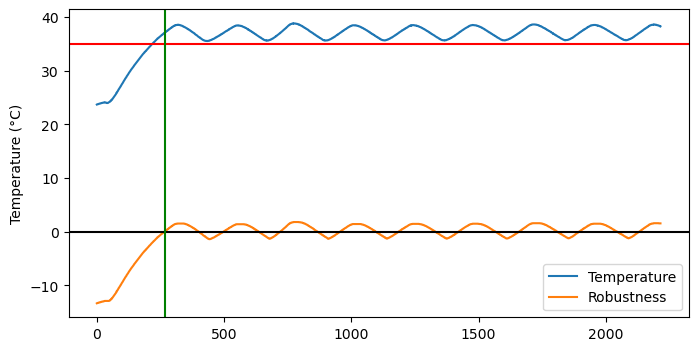

In [134]:
plt.figure(figsize=(8, 4))

# Plot temperature data on the first subplot
plt.plot(data.index, data.average_temperature, label='Temperature')
plt.plot(data.index, robustness, label='Robustness')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.axhline(y = 35, color = 'r', linestyle = '-') # shows when temperature is above 30 degrees
plt.axhline(y = 0, color = 'black', linestyle = '-') # shows when property is true
plt.axvline(x = first_moment, color = 'g', linestyle = '-') # shows at what time stamp the property becomes true

# Add a title to the shared X-axis
fig.suptitle('Temperature and Robustness Over Time')

# Show the plots
plt.show()

#### Specification 2: Checking incubator temperature in relation to the heater

Here, we're going to see if the incubator temperature reaches a particular value after the heater is on.

In [137]:
import sys
import csv
import rtamt
import os

from rtamt.spec.stl.discrete_time.specification import Semantics

def monitor():

    spec = rtamt.StlDiscreteTimeSpecification(semantics=rtamt.Semantics.STANDARD)
    spec.name = 'Incubator temp'
    spec.declare_var('average_temperature', 'float')
    spec.set_var_io_type('average_temperature', 'output')
    spec.declare_var('heater_on', 'float')
    spec.set_var_io_type('heater_on', 'input')
    spec.spec = '((heater_on == 1) implies eventually[0:5] (average_temperature >= 35))'
    try:
        spec.parse()
        spec.pastify()
    except rtamt.RTAMTException as err:
        print('RTAMT Exception: {}'.format(err))
        sys.exit()

    first_moment = -1
    robustness = []
    for i in range(len(data['average_temperature'])):
        rob = spec.update(i, [('average_temperature', data['average_temperature'][i]),('heater_on', data['heater_on'][i])])
        robustness.append(rob)
        if rob > 0 and first_moment == -1:
            first_moment = i
        
    #print('Robustness: {}'.format(robustness))
    return robustness, first_moment
robustness,first_moment = monitor()
print("Satisifed at time stamp: " + str(first_moment))

Satisifed at time stamp: 0


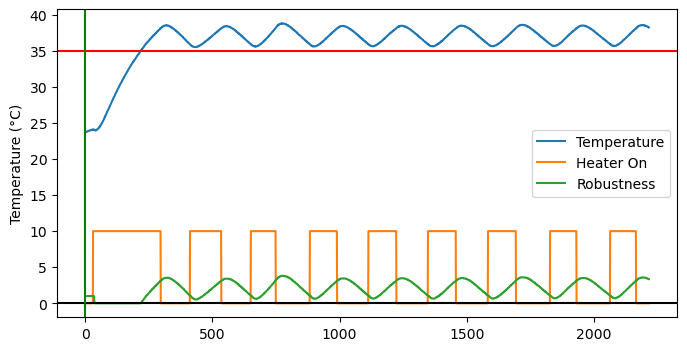

In [138]:
plt.figure(figsize=(8, 4))

# Plot temperature data on the first subplot
plt.plot(data.index, data.average_temperature, label='Temperature')
plt.plot(data.index, data.heater_on*10, label='Heater On')
plt.plot(data.index, robustness, label='Robustness')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.axhline(y = 35, color = 'r', linestyle = '-') # shows when temperature is above 30 degrees
plt.axhline(y = 0, color = 'black', linestyle = '-') # shows when property is true
plt.axvline(x = first_moment, color = 'g', linestyle = '-') # shows at what time stamp the property becomes true

# Add a title to the shared X-axis
fig.suptitle('Temperature and Robustness Over Time')

# Show the plots
plt.show()

### Exercises:

1. What do the two specifications mean in **natural language**? As in, how would you explain them to someone else in words.
2. The second plot shows that the robustness is 0 near the beginning of the trace. This means the specification is failing. Why does this happen?
3. Experiment with the first specification. Try changing the 'eventually' operator to 'always', the time bounds, or changing the temperature value. Report three experiments by:
    - writing the specification you chose
    - showing the resulting plot, and
    - describing what the plot shows and how it relates to the specification
4. Perform and report three more experiments for the second specification.